# Task 1 QOSF Mentorship Program
Task 1 consisted of 2 sections and a 3rd bonus section. The first section utilizes a statevector and the Kronecker product to simulate X, H, and CNOT gates on up to 15 qubits. The second section is similar but uses a tensor to represent the quantum state along with the tesnor dot product on specific axes to simulate X, H, and CNOT gates on up to 31 qubits. The bonus section answers some additional questions.

## Statevector

In this section, the code below uses a statevector while initializing qubits and performing X, H, and CNOT gates. The functionality is split into multiple components and error handling is included. Example printouts are provided during the process as evidence of the expected results.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

After doing the necessary imports, the I, X, H, CNOT, P0, and P1 matrices are implemented as global variables.

In [2]:
I = np.array([[1, 0],[0,1]])
X = np.array([[0,1],[1,0]])
H = (1/(np.sqrt(2))) * np.array([[1,1], [1, -1]])
CNOT = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

# Projector matrices for CNOTs
P0 = np.array([[1, 0],[0,0]])
P1 = np.array([[0, 0],[0,1]])

In order to initialize the statevector, the number of qubits are passed in and statevector is created with a default value of zero.

In [3]:
def init_sv(num_qubits: int) -> np.array:
    """Initialize the state vector and set the value to zero"""
    sv = np.zeros(2**num_qubits)
    # init state vector to 0
    sv[0] = 1
    return sv

Next, a generic operation function is called passing in a pre-defined X, H, or CNOT operation matrix, the qubit(s) to operate on, and the current statevector. The function does some basic error handling ensuring that the qubit(s) being acted on is(are) valid. The CNOT operation is handled as a special case to ensure both scenarios of a control being zero and a control being one are handled appropriately, as well as the P0 and P1 operations being used along with X. The Kronecker product is used to generate the operation matrices. The dot product of the operation matrices and the statevector transposed produces the new statevector.

In [4]:
def operate_on_sv(operation, qubits, statevector: np.array) -> np.array:
    """Performs the operation on the statevector 

    Args:
        operation: Operation to perform
        qubits: an int or list of ints representing the qubits to be acted on
        statevector: current statevector

    Returns:
        The new statevector after the operation
    """
    qubits = [qubits] if isinstance(qubits, int) else qubits

    total_number_qubits = int(np.log2(len(statevector)))

    # Handle error cases
    if len(qubits) > 2:
        raise AttributeError("qubits can contain at max 2 values")
    elif(len(qubits) == 2 and not np.array_equal(operation, CNOT)):
        raise AttributeError("only 2 qubit gate is CNOT")
    elif(not all(q in range(1, total_number_qubits+1) for q in qubits)):
        raise AttributeError("Qubits to act upon are not valid. If an operation acts upon a \
                             single qubit please enter an integer. If the operation acts on \
                             two qubit, include a list of integers with the first integer \
                             being the control and the second integer being the target.")

    # Handle CNOT case
    elif(len(qubits) == 2):
        control_is_zero = []
        control_is_one = []
        for i in range(1, total_number_qubits+1):
            # control qubit
            if i == qubits[0]:
                control_is_zero.append(P0)
                control_is_one.append(P1)
            # target qubit
            elif i == qubits[1]:
                control_is_zero.append(I)
                control_is_one.append(X)
            else:
                control_is_zero.append(I)
                control_is_one.append(I)
        
        # Control is zero Kronecker product
        control_zero_matrix = np.kron(control_is_zero[0], control_is_zero[1])
        for i in range(2, total_number_qubits):
            control_zero_matrix = np.kron(control_zero_matrix, control_is_zero[i])

        # Control is one Kronecker product
        control_one_matrix = np.kron(control_is_one[0], control_is_one[1])
        for i in range(2, total_number_qubits):
            control_one_matrix = np.kron(control_one_matrix, control_is_one[i])

        return np.dot(np.add(control_zero_matrix, control_one_matrix), np.conjugate(statevector.transpose()))
    
    # Handle single qubit operations
    else:
        operation_krons = []
        for i in range(1, total_number_qubits+1):
            # operation qubit
            if i == qubits[0]:
                operation_krons.append(operation)
            else:
                operation_krons.append(I)

        # piece together the Kronecker product
        operation_matrix = np.kron(operation_krons[0], operation_krons[1])
        for i in range(2, total_number_qubits):
            operation_matrix = np.kron(operation_matrix, operation_krons[i])

        return np.dot(operation_matrix, np.conjugate(statevector.transpose()))

        


Below is an example of a 3 qubit circuit with the X, H, and CNOT gates applied sequentially. 

In [5]:
num_qubits = 3
statevector = init_sv(num_qubits)
statevector = operate_on_sv(X, 1, statevector)
statevector = operate_on_sv(H, 1, statevector)
statevector = operate_on_sv(CNOT, [1, 2], statevector)
print(statevector)

[ 0.70710678  0.          0.          0.          0.          0.
 -0.70710678  0.        ]


In order to be able to plot the runtime of performing an initialization and X, H, and CNOT gates as a function of the number of qubits, a function was needed to perform the different operations and capture the runtime and variables used during the tests. While each qubit is initialized to zero (statevector[0] is 1 with the rest 0s), the qubits involved in the operations are random. The same qubit can be used in multiple operations, but the control and target qubit are unique. 

If additional, more comprehensive results are needed, this function could be modified to average over a specified number of shots per qubit.

In [6]:
def run_sv_experiment(num_qubits: int) -> tuple[float, int, int, int, int]:
    """Runs the predetermined experiment of X, H, and CNOT operations.
    The time it takes to run the operations is saved and returned
    
    Args:
        num_qubits: how many qubits to use with the experiment
        
    Returns:
        Time in seconds it took to run the operations
    """

    # determine X, H, control, and target qubits at random before starting
    control_qubit, target_qubit = np.random.choice(range(1, num_qubits+1), size=2, replace=False)
    x_qubit = np.random.choice(range(1, num_qubits+1), size=1)
    h_qubit = np.random.choice(range(1, num_qubits+1), size=1)
    
    start_time = time.time()
    statevector = init_sv(num_qubits)
    statevector = operate_on_sv(X, x_qubit, statevector)
    statevector = operate_on_sv(H, h_qubit, statevector)
    statevector = operate_on_sv(CNOT, [control_qubit,target_qubit], statevector)
    return(time.time()-start_time, x_qubit, h_qubit, control_qubit, target_qubit)

With the experiment function defined, I first did testing to determine how many qubits could the system handle. I found that at 16 qubits, the Python kernel consistently crashed. Therefore, the experiments below are for qubit counts of 2 to 15. The results are printed in an easy to read format.

In [7]:
sv_results = {}

# Starting at 16 qubits the kernel crashes 
for num_qubits in range(2, 16):
    sv_results[num_qubits] = run_sv_experiment(num_qubits)


for qubit, result in sv_results.items():
    print(f"{qubit} qubits - {result[0]} seconds")

2 qubits - 0.0003838539123535156 seconds
3 qubits - 0.00021004676818847656 seconds
4 qubits - 0.0001461505889892578 seconds
5 qubits - 0.0004730224609375 seconds
6 qubits - 0.0003638267517089844 seconds
7 qubits - 0.0018322467803955078 seconds
8 qubits - 0.0035858154296875 seconds
9 qubits - 0.01675581932067871 seconds
10 qubits - 0.07144713401794434 seconds
11 qubits - 0.16494488716125488 seconds
12 qubits - 0.5663979053497314 seconds
13 qubits - 2.5202512741088867 seconds
14 qubits - 10.65863585472107 seconds
15 qubits - 46.343027114868164 seconds


Text(0.5, 1.0, 'Runtime of operations with a state vector as a function of number of qubits')

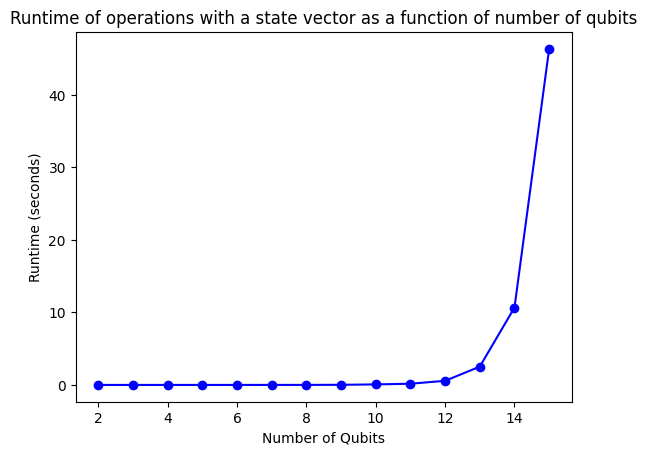

In [8]:
#Retrieve the qubits and runtimes for plotting
qubits = list(sv_results.keys())
runtimes = [sv_results[n][0] for n in qubits]

# Plotting the data
plt.plot(qubits, runtimes, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of operations with a state vector as a function of number of qubits')

Above is the plot of runtime of the operations as a function of the number of qubits. As mentioned previously, at 16 qubits the Python kernel crashes. 

## State Tensor
In this section, the code below uses a tensor to respresent the state while initializing qubits and performing X, H, and CNOT gates. The functionality is split into multiple components and error handling is included. Example printouts are provided during the process as evidence of the expected results.

The initialization for the tensor and setting it to zero are a little different due to the different shape of the tensor.

In [9]:
def init_tensor(num_qubits: int) -> np.array:
    """Initialize the state vector and set the value to zero"""
    st = np.zeros((2,)*num_qubits)
    # init state vector to 0
    st[(0,)*num_qubits] = 1
    return st

The function below performs the X, H, and CNOT operations on a provided state tensor. Error handling is included to ensure that the qubit(s) being acted upon is(are) valid. The tensor shape allows for unique handling of the CNOT operation. Using `moveaxis` and `reshape` we are able to manipulate the system so that CNOT matrix can be applied to the appropriate qubits followed by `reshape` and `moveaxis` to put manipulate the system back. 

In [10]:
def tensor_operation(operation, qubits, state_tensor: np.array) -> np.array:
    """Performs the operation on the tensor representation 

    Args:
        operation: Operation to perform
        qubits: an int or list of ints representing the qubits to be acted on
        state_tensor: current state in tensor form

    Returns:
        The new state as a vector after the operation
    """
    qubits = [qubits] if isinstance(qubits, int) else qubits

    total_number_qubits = len(np.shape(state_tensor))

    # Handle error cases
    if len(qubits) > 2:
        raise AttributeError("qubits can contain at max 2 values")
    elif(len(qubits) == 2 and not np.array_equal(operation, CNOT)):
        raise AttributeError("only 2 qubit gate is CNOT")
    elif(not all(q in range(1, total_number_qubits+1) for q in qubits)):
        raise AttributeError("Qubits to act upon are not valid. If an operation acts upon a single \
                             qubit please enter an integer. If the operation acts on two qubit, \
                             include a list of integers with the first integer being the control and \
                             the second integer being the target.")

    # Handle CNOT case
    elif(len(qubits) == 2):
        temp_state_tensor = np.moveaxis(state_tensor, [qubits[0]-1, qubits[1]-1], [0, 1])
        shaped_state_tensor = np.reshape(temp_state_tensor, (4,) + (2,)*(temp_state_tensor.ndim-2)) 

        after_cnot_state = np.tensordot(operation, shaped_state_tensor, axes=([1], [0]))
        new_shaped_state = np.reshape(after_cnot_state, (2, 2) + (2,) *(temp_state_tensor.ndim-2))
        return np.moveaxis(new_shaped_state, [0,1], [qubits[0]-1, qubits[1]-1])
    
    # Handle single qubit operations
    else:
        temp_state_tensor = np.tensordot(operation, state_tensor, axes=(1, qubits[0]-1))
        return np.moveaxis(temp_state_tensor, 0, qubits[0]-1)

Below is an example of a 3 qubit circuit with the X, H, and CNOT gates applied sequentially. The difference between the vector form and tensor form can be clearly seen with the state tensor that is printed.

In [11]:
num_qubits =3
state_tensor = init_tensor(num_qubits)
state_tensor = tensor_operation(X, 1, state_tensor)
state_tensor = tensor_operation(H, 1, state_tensor)
state_tensor = tensor_operation(CNOT, [1,2], state_tensor)
print(state_tensor)


[[[ 0.70710678  0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [-0.70710678  0.        ]]]


In order to be able to plot the runtime of performing an initialization and X, H, and CNOT gates as a function of the number of qubits, a function was needed to perform the different operations and capture the runtime and variables used during the tests. While each qubit is initialized to zero, the qubits involved in the operations are random. The same qubit can be used in multiple operations, but the control and target qubit are unique. 

If additional, more comprehensive results are needed, this function could be modified to average over a specified number of shots per qubit.

In [12]:
def run_tensor_experiment(num_qubits: int) -> float:
    """Runs the predetermined experiment of X, H, and CNOT operations.
    The time it takes to run the operations is saved and returned
    
    Args:
        num_qubits: how many qubits to use with the experiment
        
    Returns:
        Time in seconds it took to run the operations
    """

    # determine control and target qubits at random before starting
    control_qubit, target_qubit = np.random.choice(range(1, num_qubits+1), size=2, replace=False)
    x_qubit = np.random.choice(range(1, num_qubits+1), size=1)
    h_qubit = np.random.choice(range(1, num_qubits+1), size=1)
    start_time = time.time()
    state_tensor = init_tensor(num_qubits)
    state_tensor = tensor_operation(X, x_qubit, state_tensor)
    state_tensor = tensor_operation(H, h_qubit, state_tensor)
    state_tensor = tensor_operation(CNOT, [control_qubit, target_qubit], state_tensor)
    return time.time()-start_time, control_qubit, target_qubit
    

With the experiment function defined, I first did testing to determine how many qubits could the system handle using tensors. I found that at 32 qubits, the Python kernel consistently crashed. Therefore, the experiments below are for qubit counts of 2 to 31. The results are printed in an easy to read format.

In [13]:
results = {}

# Starting at 32 qubits the kernel crashes
for num_qubits in range(2, 32):
    results[num_qubits] = run_tensor_experiment(num_qubits)

for qubit, result in results.items():
    print(f"{qubit} qubits - {result[0]} seconds")

2 qubits - 0.0002701282501220703 seconds
3 qubits - 6.985664367675781e-05 seconds
4 qubits - 5.602836608886719e-05 seconds
5 qubits - 5.2928924560546875e-05 seconds
6 qubits - 5.888938903808594e-05 seconds
7 qubits - 0.0004589557647705078 seconds
8 qubits - 0.0007369518280029297 seconds
9 qubits - 0.00021910667419433594 seconds
10 qubits - 0.0003390312194824219 seconds
11 qubits - 9.393692016601562e-05 seconds
12 qubits - 8.487701416015625e-05 seconds
13 qubits - 0.00017404556274414062 seconds
14 qubits - 0.00012302398681640625 seconds
15 qubits - 0.0003018379211425781 seconds
16 qubits - 0.0003490447998046875 seconds
17 qubits - 0.06942582130432129 seconds
18 qubits - 0.026070117950439453 seconds
19 qubits - 0.0036499500274658203 seconds
20 qubits - 0.007859945297241211 seconds
21 qubits - 0.02284383773803711 seconds
22 qubits - 0.03483104705810547 seconds
23 qubits - 0.11348676681518555 seconds
24 qubits - 0.15967297554016113 seconds
25 qubits - 0.30428218841552734 seconds
26 qubits 

Text(0.5, 1.0, 'Runtime of operations with a state tensor as a function of Number of Qubits')

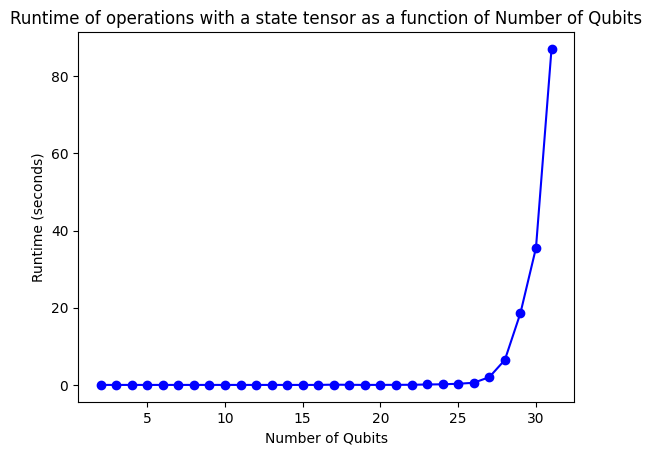

In [14]:
#Retrieve the qubits and runtimes for plotting
qubits = list(results.keys())
runtimes = [results[n][0] for n in qubits]

# Plotting the data
plt.plot(qubits, runtimes, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of operations with a state tensor as a function of Number of Qubits')

The plot above shows the runtime of the operations in seconds with state tensors as a function of the number of qubits. Again, the Python kernel was able to handle 31 qubits before crashing which is over double the number of qubits (15) that the statevector was able to handle. Both plots look similar in that prior to the last few data points, the runtime is relatively flat across the number of qubits. 

## Bonus
1. For sampling the from the final states, it is possible to use `numpy.random.choice` since it includes a parameter `p` which is an array of the probabilities associated with each entry in paramater `a`. The statevector could easily be turned into a vector of the amplitude probabilities (aka `p`) by squaring the values. The `a` parameter would simply be the range from 0 to the 2^n-1. Luckily, `numpy.random.choice` includes the `size` parameter which can be used as the number of `shots`. For a tensor, you could reshape it to a statevector and then sample from it.

2. For the statevector it would be relatively easy to change the function to produce an expectation value instead of a new statevector. If we changed the functions, the general idea for the state vector would be `np.dot(statevector_dagger, np.dot(operation, statevector))`. If the question however is asking about getting an expectation value from the final results after the X, H, and CNOT, it would be more complicated. If we were able to generate the operation matrix for all three of the operations combined, then we could follow the same general idea but that would be much more difficult. Again, for the tensor form, it would probably be easiest to reshape and flatten it to use a similar method as the statevector.

**RESOURCES**:
The Numpy API reference, wikipedia, ChatGPT, and Gemini were used as resources in completing this project.